In [45]:
#  !pip install -U "transformers[torch]" "datasets>=2.16.0" "accelerate>=0.26.0" \
#  "evaluate" "pandas>=2.0.0" "matplotlib" "scikit-learn" "umap-learn" "huggingface_hub"

In [46]:

# hide_output
from datasets import load_dataset

emotions = load_dataset("emotion")

In [47]:
from huggingface_hub import notebook_login

notebook_login()

In [48]:

emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [49]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [50]:
train_ds[1]['text']

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

0: sadness (เศร้า)
1: joy (ดีใจ/มีความสุข)
2: love (รัก)
3: anger (โกรธ)
4: fear (กลัว)
5: surprise (ประหลาดใจ)


In [51]:

print(train_ds.features)

print(train_ds[:5])

{'text': Value('string'), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}
{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [52]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [53]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


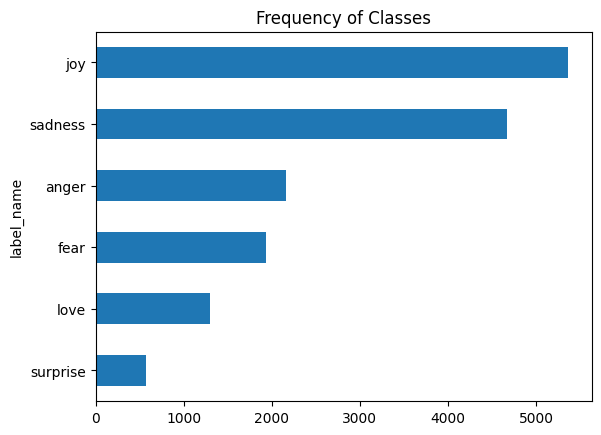

In [54]:

import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [55]:
emotions.reset_format()

In [56]:
# hide_output
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [57]:

text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [58]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [59]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [60]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [61]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


เติม Special Token  เพื่อ

บอกโครงสร้างประโยค, ควบคุมพฤติกรรมการเรียนรู้ของโมเดล, ทำให้โมเดล ไม่เห็นเฉลยทั้งหมด ตอนเทรน โดย [unk] =unknown, [CLS] = token แรกของทุก sequence [SEP] = คั่นประโยค [Mask] = ซ่อยคำเพื่อไม่เห็นเฉลยทั้งหมด

In [62]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


เข้ารหัส token ทั้งชุดข้อมูล

In [63]:
# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [64]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


attention_mask คือแผนที่บอกโมเดลว่า token ไหน มีตัวตนจริง  1 คือใช้ 0 คือไม่ใช้ กัน padding token

In [65]:
emotions_encoded["train"][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,


โหลดโมเดล

In [66]:
import torch
import torch.nn.functional as F
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

ทดสอบดูขนาดของข้อมูล Tensor (batch,sequence_Length) ที่เป็น 6 เพราะเติม Token พิเศษ [CLS] this is a test [SEP]

In [67]:

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(tokenizer.decode(inputs["input_ids"][0]))

Input tensor shape: torch.Size([1, 6])
[CLS] this is a test [SEP]


เอา input ผ่าน encoder ของโมเดลเรียบร้อยแล้ว และได้ vector ออกมา

In [68]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [69]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [70]:

outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

ดึงค่า hidden state ของแต่ละประโยคออกมาแล้วใส่ใน json เดิมใช่ไหม ชื่อตัวแปรhidden state

In [71]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [72]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

เวกเตอร์ + UMAP + linear probe = การวัด representation ก่อน fine-tune เพื่อ วัดศักยภาพ representation แทนการ validate ตรง ๆ

In [73]:
#hide_output
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [74]:
emotions_hidden["train"].column_names
print(emotions_hidden["train"][0])

{'label': tensor(0), 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,

การทำ representation analysis + visualization

In [75]:

import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

ใช้ UMAP ในการลดมิติ hidden state แล้วพล็อตดูว่า class แต่ละอัน แยกกลุ่มกันได้ดีแค่ไหน X คือค่าแกนที่ 1 Y คือค่าแกนที่ 2

In [76]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.291993,3.367907,0
1,-3.118443,3.647168,0
2,5.289551,6.942588,3
3,-2.624567,5.729236,2
4,-3.502113,5.611781,3


แผนที่การกระจายตัวของ sentence embeddings แยกตาม class

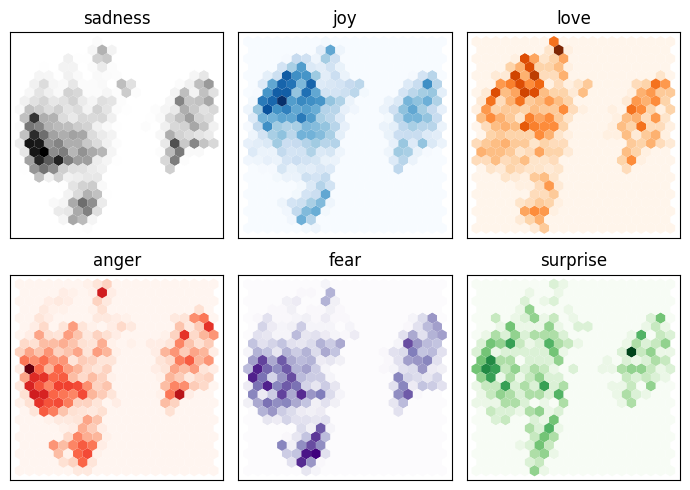

In [77]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

ทำการเทรนตัวจำแนกประเภทเพื่อเรียนรู้ความสัมพันธ์ระหว่าง sentence embedding ของแต่ละประโยคกับคลาสอารมณ์ที่กำหนด

In [78]:
#hide_output
# We increase `max_iter` to guarantee convergence
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [79]:

lr_clf.score(X_valid, y_valid)

0.634

In [80]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

จาก confusion matrix พบว่า เมื่อใช้ pretrained embedding ร่วมกับ Logistic Regression ผลลัพธ์ยังมีการสับสนระหว่างคลาสค่อนข้างมาก อย่างไรก็ตาม หลังจากทำการ fine-tuning โมเดล Transformer กับข้อมูลอารมณ์โดยตรง ความสามารถในการจำแนกคลาสดีขึ้นอย่างชัดเจน

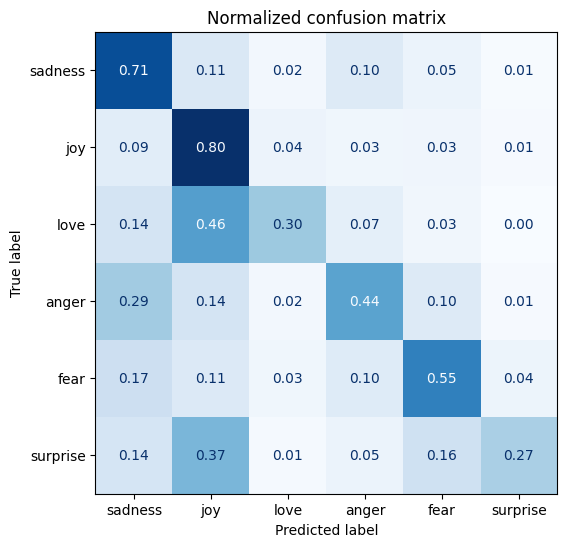

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

ทำการ Fine-Tuned โมเดลด้วยข้อมูลดาต้าเซต

In [82]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

In [83]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


In [84]:
# from huggingface_hub import notebook_login

# notebook_login()

กำหนด parameter ที่ใช้ในการเทรน

In [85]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

ทำการ Fine Tuned

In [87]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  )
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.825294,0.321592,0.902000,0.900816
2,0.252682,0.218154,0.926000,0.925598


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

ทดสอบกับชุดข้อมูล Validation Set

In [88]:
# hide_output
preds_output = trainer.predict(emotions_encoded["validation"])

In [89]:
preds_output.metrics

{'test_loss': 0.21815386414527893,
 'test_accuracy': 0.926,
 'test_f1': 0.92559801639807,
 'test_runtime': 4.2658,
 'test_samples_per_second': 468.842,
 'test_steps_per_second': 7.501}

In [90]:
y_preds = np.argmax(preds_output.predictions, axis=1)

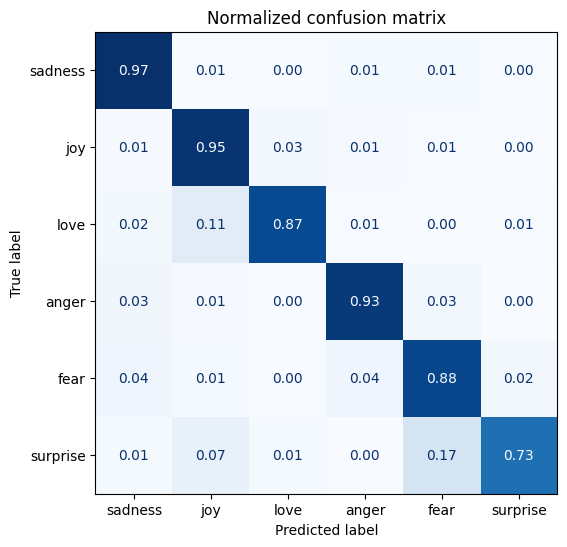

In [91]:
plot_confusion_matrix(y_preds, y_valid, labels)


ตรวจสอบผลลัพธ์รายประโยค  หลังการ fine-tuning

In [92]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [93]:
# hide_output
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

เอาผลการทำนายรายประโยคหลัง fine-tuning มาอยู่ในรูป DataFrame เพื่อทำ error analysis

In [94]:

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [95]:
#hide_output
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.771506
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.600415
1950,i as representative of everything thats wrong ...,surprise,sadness,5.194094
1801,i feel that he was being overshadowed by the s...,love,sadness,5.035434
177,im sure much of the advantage is psychological...,sadness,joy,4.967928
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.908259
882,i feel badly about reneging on my commitment t...,love,sadness,4.862911
1509,i guess this is a memoir so it feels like that...,joy,fear,4.756220
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.503661
1683,i had applied for a job and they had assured m...,anger,joy,4.481783


In [96]:
#hide_output
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.017713
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017734
861,i am feeling awfully lonely today and i dont w...,sadness,sadness,0.018192
1303,i feel pathetic and uninspired,sadness,sadness,0.018221
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.018223
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.018243
578,i got to christmas feeling positive about the ...,joy,joy,0.018275
214,i feel lonely and he always talks to me,sadness,sadness,0.018324
445,i just listened to ed and then after feeling r...,sadness,sadness,0.018378
697,i was missing him desperately and feeling idio...,sadness,sadness,0.018441


Push Model ขึ้น Hugging Face

In [97]:
#hide_output
trainer.push_to_hub(commit_message="Training completed!")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...emotion/model.safetensors:  19%|#8        | 50.3MB /  268MB            

  ...emotion/training_args.bin: 100%|##########| 5.20kB / 5.20kB            

CommitInfo(commit_url='https://huggingface.co/Posathip/distilbert-base-uncased-finetuned-emotion/commit/cc3256bd3f377d75b184f2bc828953b20d51ec7a', commit_message='Training completed!', commit_description='', oid='cc3256bd3f377d75b184f2bc828953b20d51ec7a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Posathip/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='Posathip/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)

ทำการ Download โมเดลจาก  Hugging Face ที่ Deploy ไป

In [98]:

from transformers import pipeline


model_id = "Posathip/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

ทดสอบผลลัพธ์ของประโยค

Tweet: I very enjoy in this class.
sadness: 93.29%
joy: 4.62%
love: 0.61%
anger: 0.57%
fear: 0.55%
surprise: 0.36%
--------------------


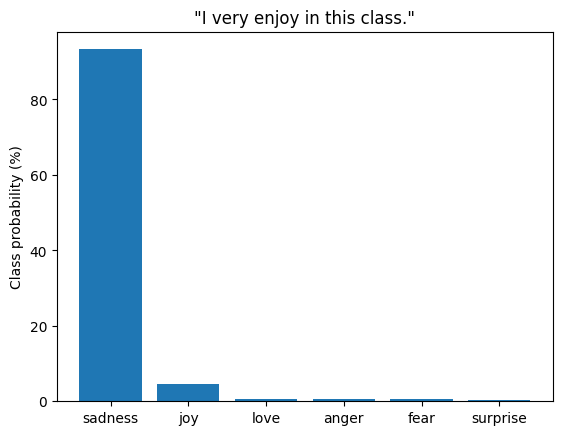

In [111]:
import pandas as pd
import matplotlib.pyplot as plt


emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]

custom_tweet = "I very enjoy in this class."



preds = classifier(custom_tweet, top_k=None)

print(f"Tweet: {custom_tweet}")


results = preds[0] if isinstance(preds[0], list) else preds

for i, pred in enumerate(results):
    # Map the emotion names to the results
    label_name = emotions[i]
    print(f"{label_name}: {pred['score']*100:.2f}%")

print("-" * 20)

# Create DataFrame and plot
preds_df = pd.DataFrame(results)
preds_df["label_name"] = emotions

plt.bar(preds_df["label_name"], 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()